In [45]:
import numpy as np
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import awkward as ak
import seaborn as sn
import atlas_mpl_style as ampl
ampl.use_atlas_style()  

In [46]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from imcal import *

In [47]:
#Uncomment the data type and classification type

#DATA_TYPE = "low-level"
DATA_TYPE = "high-level"
CUT = True

BH_LABELS = ["BH_n2_M10", "BH_n4_M10", "BH_n6_M10"]
#BH_LABELS = ["BH_n4_M8", "BH_n4_M10", "BH_n4_M12"]
N_BH_LABELS = len(BH_LABELS)
SPH_LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL"]
N_SPH_LABELS = len(SPH_LABELS)
LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL"] + BH_LABELS
SPH_PLOT_LABELS = ["SPH_9"]
BH_PLOT_LABELS = BH_LABELS

print(LABELS)

if CUT:
    BH_N_EVENTS = [6000, 15000, 7000]
    #BH_N_EVENTS = [15000, 15000, 15000]
    SPH_N_EVENTS = [20000]
    N_EVENTS = 3000
    N_MIN = 5
    ST_MIN = 7 #TeV
    ETA_MAX = 2.4
    PT_MIN = 70 #GeV
    BH_CUT_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/BH/50/{label}_test_res50_STmin7_Nmin5_3000_events.h5" for label in BH_LABELS]
    SPH_CUT_DATAPATHS = ["/disk/atlas3/data_MC/2dhistograms/sph/50/PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_test_res50_STmin7_Nmin5_3000_events.h5"]
    
else:
    BH_N_EVENTS = [3000]*len(BH_LABELS)
    SPH_N_EVENTS = [3000]*len(SPH_LABELS)
    N_EVENTS = 3000

DATA_PATH = "/disk/atlas3/data_MC/delphes/"

#Set data paths

SPH_FILENAMES = [f"{label}_{n}events.root:Delphes" for label, n in zip(SPH_LABELS, SPH_N_EVENTS)]
BH_FILENAMES = [f"{label}_{n}events.root:Delphes" for label, n in zip(BH_LABELS, BH_N_EVENTS)]

SPH_DATAPATHS = [f"{DATA_PATH}/{FILENAME}" for FILENAME in SPH_FILENAMES]
BH_DATAPATHS = [f"{DATA_PATH}/{FILENAME}" for FILENAME in BH_FILENAMES]

['PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL', 'BH_n2_M10', 'BH_n4_M10', 'BH_n6_M10']


In [48]:
#sn.set_palette("Paired", int(N_BH_LABELS + N_SPH_LABELS))
sn.set_theme(context="notebook", style="white", palette="deep", font='sans-serif', font_scale=1.5, color_codes=True, rc=None)
#line_styles = ["-", "--", "-", "--", "-", "--"]
#bh_colors = ["#8da0cb", "#66c2a5", "#e78ac3"]
bh_colors = sn.color_palette("deep", n_colors = len(BH_LABELS))
sph_colors = ["#FB66FF"]#, "#b30000"]
#line_styles = ["-", "-", "-", "."]
line_styles = ["-", "-", "-", "-", "-", "-", "-", "-", "-", "-"]
#paper_colors = ["#8da0cb", "#66c2a5", "#e78ac3",  "#fc8d62"]
paper_colors = sn.color_palette("deep", n_colors = len(BH_LABELS)+1)
paper_colors[-1] = sph_colors[0]

In [49]:
def load_cut_event_numbers(hdf5file):
    with h5py.File(hdf5file, 'r') as f:
                keys = list(f.keys())
                data = [f[key]["event_id"] for key in keys]
                #create array
                ids = np.array(data).flatten()
                ids = ids.tolist()
                ids = [int(item[0]) for item in ids]
    return ids

These are some examples of how to look at root files using uproot and awkward arrays. More info in this tutorial:
https://hub.gke2.mybinder.org/user/jpivarski-2020--ep2020-tutorial-7h7oraqf/lab/tree/tutorial.ipynb


In [50]:
#Open file in with-function will close it when you exit

def get_arrays(data_paths, n_events, id_paths=None):
    clusters = [load_data(path, "Tower", 
                            ["Tower.ET", "Tower.Eta", "Tower.Phi", "Tower.Eem", "Tower.Ehad", "Tower.E"], n) for n, path in zip(n_events, data_paths)]
    
    tracks = [load_data(path, "Track", 
                        ["Track.PT", "Track.Eta", "Track.Phi"], n) for n, path in zip(n_events, data_paths)]

    jets = [load_data(path, "Jet", 
                            ["Jet.PT", "Jet.Eta", "Jet.Phi"], n) for n, path in zip(n_events, data_paths)]
                
    met = [load_data(path, "MissingET", 
                            ["MissingET.MET", "MissingET.Eta", "MissingET.Phi"], n) for n, path in zip(n_events, data_paths)]
    
    electrons = [load_data(path, "Electron", 
                            ["Electron.PT", "Electron.Eta", "Electron.Phi", "Electron.Charge"], n) for n, path in zip(n_events, data_paths)]

    muons = [load_data(path, "Muon", 
                            ["Muon.PT", "Muon.Eta", "Muon.Phi", "Muon.Charge"], n) for n, path in zip(n_events, data_paths)]

    photons = [load_data(path, "Photon", 
                            ["Photon.PT", "Photon.Eta", "Photon.Phi"], n) for n, path in zip(n_events, data_paths)]
    
    event_numbers = [load_data(path, "Event", 
                            ["Event.Number"], n) for n, path in zip(n_events, data_paths)]
    if CUT:
        cut_event_ids = [load_cut_event_numbers(id_path) for id_path in id_paths]    
        print(f"Events before cut: {[len(item) for item in clusters]}")
        event_ids = [ak.to_numpy(ar["Number"]).flatten() for ar in event_numbers]
        matching_ids = [np.argwhere(np.isin(ids, cut_ids)).ravel() for ids, cut_ids in zip(event_ids, cut_event_ids)]
        clusters = [item[ids] for item, ids in zip(clusters, matching_ids)]
        tracks = [item[ids] for item, ids in zip(tracks, matching_ids)]
        jets = [item[ids] for item, ids in zip(jets, matching_ids)]
        met = [item[ids] for item, ids in zip(met, matching_ids)]
        electrons = [item[ids] for item, ids in zip(electrons, matching_ids)]
        muons = [item[ids] for item, ids in zip(muons, matching_ids)]
        photons = [item[ids] for item, ids in zip(photons, matching_ids)]
        print(f"Events after cut: {[len(item) for item in clusters]}")

    return clusters, tracks, jets, met, electrons, muons, photons

if CUT:
    BH_clusters, BH_tracks, BH_jets, BH_met, BH_electrons, BH_muons, BH_photons = get_arrays(BH_DATAPATHS, BH_N_EVENTS, BH_CUT_DATAPATHS)
    sph_clusters, sph_tracks, sph_jets, sph_met, sph_electrons, sph_muons, sph_photons = get_arrays(SPH_DATAPATHS, SPH_N_EVENTS, SPH_CUT_DATAPATHS)

else:
    BH_clusters, BH_tracks, BH_jets, BH_met, BH_electrons, BH_muons, BH_photons = get_arrays(BH_DATAPATHS)
    sph_clusters, sph_tracks, sph_jets, sph_met, sph_electrons, sph_muons, sph_photons = get_arrays(SPH_DATAPATHS)
print([len(BH_clusters[i][0]) for i in range(len(BH_clusters))])
print([len(BH_clusters[i]) for i in range(len(BH_clusters))])

Events before cut: [6000, 15000, 7000]
Events after cut: [3000, 3000, 3000]
Events before cut: [20000]
Events after cut: [3000]
[345, 375, 250]
[3000, 3000, 3000]


Text(0.5, 0, 'Number of entries in calorimeter')

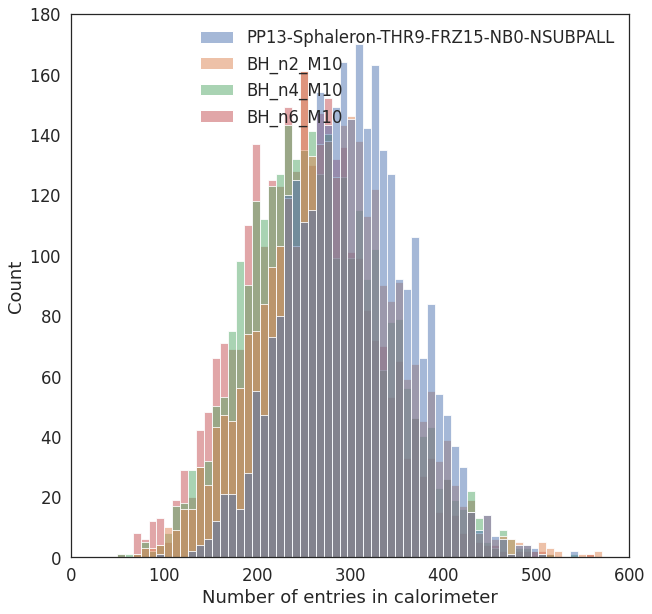

In [51]:
#How many calorimeter hits in each event?
len_sph_clusters = [[len(item) for item in cluster["ET"]] for cluster in sph_clusters]
len_bh_clusters = [[len(item) for item in cluster["ET"]] for cluster in BH_clusters]
len_clusters = len_sph_clusters + len_bh_clusters
fig, ax = plt.subplots(ncols=1, figsize=(10,10))
sn.histplot(dict(zip(LABELS, len_clusters)), ax = ax, multiple="layer", stat="count")
ax.set_xlabel("Number of entries in calorimeter")

Text(0.5, 0, 'Number of entries in track')

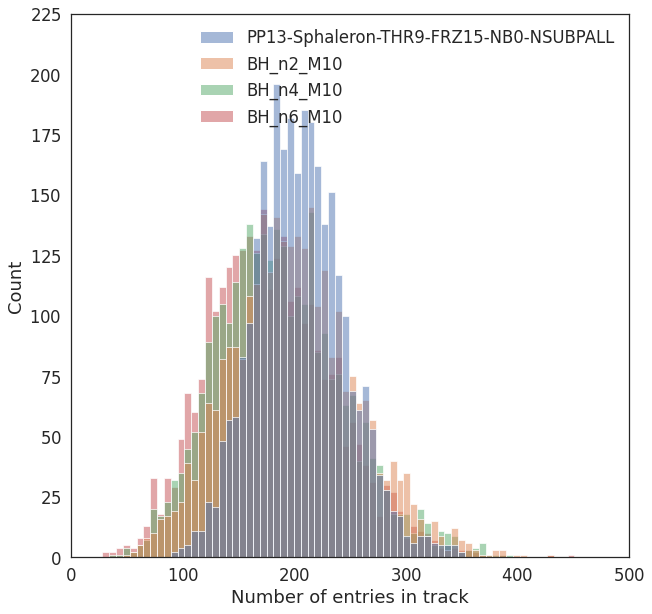

In [52]:
#How many track hits in each event?
len_sph_tracks = [[len(item) for item in cluster["PT"]] for cluster in sph_tracks]
len_bh_tracks = [[len(item) for item in cluster["PT"]] for cluster in BH_tracks]
len_tracks = len_sph_tracks + len_bh_tracks
fig, ax = plt.subplots(ncols=1, figsize=(10,10))
sn.histplot(dict(zip(LABELS, len_tracks)), ax = ax, multiple="layer", stat="count")
ax.set_xlabel("Number of entries in track")

# Jet data

In [53]:
#Extracting data for plotting from jets
def jet_data (jets):
    jets = [ak.pad_none(item, 1, axis=-1) for item in jets]
    n_jets = [np.array([len(event) for event in item.PT]) for item in jets]
    jet1_PT = [ak.to_list(item.PT[:,0]/1000) for item in jets]
    jet1_eta = [ak.to_list(item.Eta[:,0]) for item in jets]
    #jet_1_phi = [ak.to_list(item.Phi[:,0]) for item in jets]
    return jets, n_jets, jet1_PT, jet1_eta

BH_jets, n_BH_jets, BH_jet1_PT, BH_jet1_eta = jet_data(BH_jets)
sph_jets, n_sph_jets, sph_jet1_PT, sph_jet1_eta = jet_data(sph_jets)

(-2.0, 2.0)

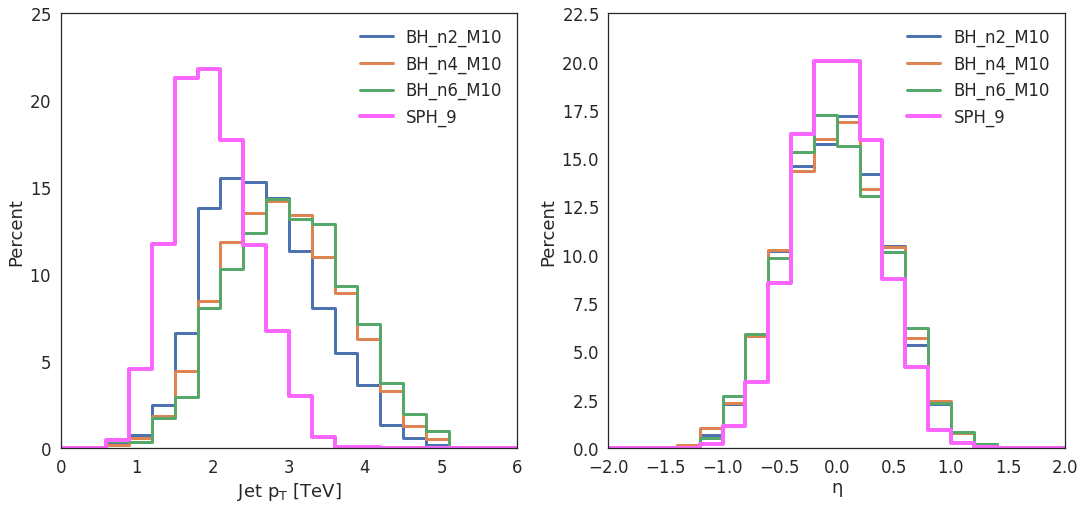

In [54]:
#jet information
fig, ax = plt.subplots(ncols=2, figsize=(18,8))
for i in range(N_BH_LABELS):
    sn.histplot(BH_jet1_PT[i], label=BH_PLOT_LABELS[i], linewidth=3, ax = ax[0], color=bh_colors[i], 
                binrange=(0, 6), bins=20, fill=False, stat="percent", common_norm=False, element="step")
for i in range(N_SPH_LABELS):
    sn.histplot(sph_jet1_PT[i], linewidth=4, label=SPH_PLOT_LABELS[i], ax = ax[0], color=sph_colors[i], 
                binrange=(0, 6), bins=20, fill=False, stat="percent", common_norm=False, element="step")

ax[0].legend()
ax[0].set_xlabel(r"Jet $p_{T}$ [TeV]")
ax[0].set_xlim(0, 6)

for i in range(N_BH_LABELS):
    sn.histplot(BH_jet1_eta[i], label=BH_PLOT_LABELS[i], linewidth=3, ax = ax[1], color=bh_colors[i], 
                binrange=(-2, 2), bins=20, fill=False, stat="percent", common_norm=False, element="step", alpha=1)
for i in range(N_SPH_LABELS):
    sn.histplot(sph_jet1_eta[i], label=SPH_PLOT_LABELS[i], ax = ax[1], linewidth=4, color=sph_colors[i], 
                binrange=(-2, 2), bins=20, fill=False, stat="percent", common_norm=False, element="step", alpha=1)

ax[1].legend()
ax[1].set_xlabel(r"$\eta$")
ax[1].set_xlim(-2, 2)


# Multiplicity plots

In [55]:
#Extracting data for plotting from particle data
def multiplicity(photons, electrons, muons):
    n_photons = [[len(event) for event in item.PT] for item in photons]
    n_electrons = [[len(event) for event in item.PT] for item in electrons]
    #separate muons by charge
    muons_neg = [item[item.Charge < 0] for item in muons]
    muons_pos = [item[item.Charge > 0] for item in muons]
    n_muons_neg = [np.array([len(event) for event in item.PT]) for item in muons_neg]
    n_muons_pos = [np.array([len(event) for event in item.PT]) for item in muons_pos]
    n_muons = [np.array([len(event) for event in item.PT]) for item in muons]
    return n_photons, n_electrons, n_muons_neg, n_muons_pos, n_muons 

n_BH_photons, n_BH_electrons, n_BH_muons_neg, n_BH_muons_pos, n_BH_muons = multiplicity(BH_photons, BH_electrons, BH_muons)
n_sph_photons, n_sph_electrons, n_sph_muons_neg, n_sph_muons_pos, n_sph_muons = multiplicity(sph_photons, sph_electrons, sph_muons)


[]

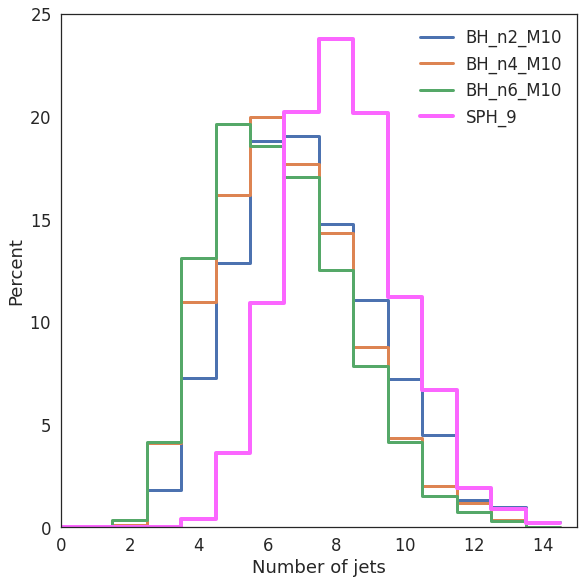

In [56]:
#jet multiplicity
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), layout="constrained")
#sn.histplot(dict(zip(BH_PLOT_LABELS + SPH_PLOT_LABELS, n_BH_jets + n_sph_jets)), ax = ax, binwidth=1.0, binrange=[-0.5, 14.5], 
#            multiple="layer", linewidth=3, alpha=1, palette=paper_colors, bins=15, fill=False, stat="percent", element="step", common_norm=False)

for i in range(N_BH_LABELS):
    sn.histplot(n_BH_jets[i], label=BH_PLOT_LABELS[i], linewidth=3, ax = ax, color=bh_colors[i], 
                binwidth=1.0, binrange=[-0.5, 14.5], bins=15, fill=False, stat="percent", common_norm=False, element="step")
for i in range(N_SPH_LABELS):
    sn.histplot(n_sph_jets[i], linewidth=4, label=SPH_PLOT_LABELS[i], ax = ax, color=sph_colors[i], 
                binwidth=1.0, binrange=[-0.5, 14.5], bins=15, fill=False, stat="percent", common_norm=False, element="step")

ax.set_xlabel("Number of jets")
ax.set_xlim(0, 15)
ax.legend()

plt.plot()

(0.0, 14.0)

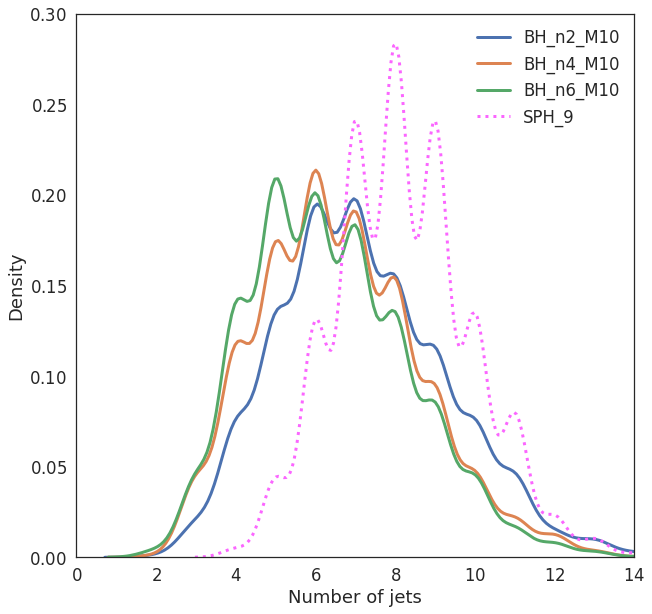

In [57]:
#jet multiplicity
fig, ax = plt.subplots(ncols=1, figsize=(10,10))
for i in range(N_BH_LABELS):
    sn.kdeplot(n_BH_jets[i], ls=line_styles[i], label=BH_PLOT_LABELS[i], linewidth=3, ax = ax, color=bh_colors[i])
for i in range(N_SPH_LABELS):
    sn.kdeplot(n_sph_jets[i], ls='dotted', linewidth=3, label=SPH_PLOT_LABELS[i], ax = ax, color=sph_colors[i])

ax.legend()
ax.set_xlabel("Number of jets")
ax.set_xlim(0, 14)


[]

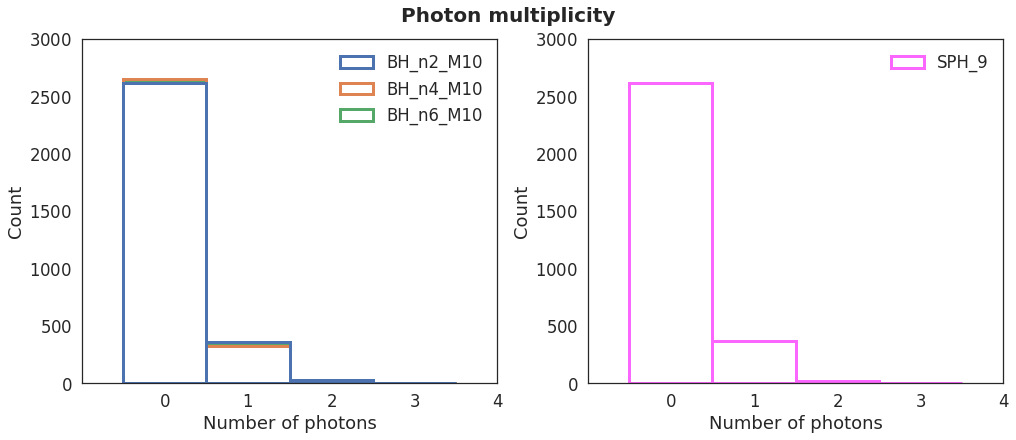

In [58]:
#photon multiplicity
fig, ax = plt.subplots(ncols=2, figsize=(14, 6), layout="constrained")
fig.suptitle("Photon multiplicity", size=20, fontweight="bold")
sn.histplot(dict(zip(BH_PLOT_LABELS, n_BH_photons)), ax = ax[0], binwidth=1.0, binrange=[-0.5, 3.5], 
            multiple="layer", stat="count", linewidth=3, fill=False)
sn.histplot(dict(zip(SPH_PLOT_LABELS, n_sph_photons)), ax = ax[1], binwidth=1.0, binrange=[-0.5, 3.5], 
            multiple="layer", stat="count", linewidth=3, palette=sph_colors, fill=False)

for axis in ax.reshape(-1):
    axis.set_xlabel("Number of photons")
    axis.set_xlim(-1, 4)
    axis.set_xticks([0,1,2,3,4])

plt.plot()

In [59]:
#muon multiplicity

def make_data(counts, labels, n_models, n_counts):
    data = [[0]*n_counts]*n_models
    for i in range(0, n_models):
        data[i] = [labels[i]] + list(counts[i])
        
        while(len(data[i]) <= n_counts):
            data[i] = data[i] + [0]
        sum_muons = np.sum([data[i][k]*(k-1) for k in range(1, n_counts)])
        data[i] = data[i] + [sum_muons]
    return data

def make_table(n_muons, labels, n_labels, type):
    count_mu = [np.unique(item, return_counts=True)[1] for item in n_muons]

    col_names = ["Model", "0", "1", "2", "3", "4", f'Total {type}']
    n_counts = 5 #can be dynamically coded, but should not be more than 4 muons
    
    data_mu = make_data(count_mu, labels, n_labels, n_counts)
    df = pd.DataFrame(data_mu, columns=col_names)
    return df

BH_mu_neg = make_table(n_BH_muons_neg, BH_LABELS, N_BH_LABELS, 'μ-')
print("The number of muons in each event in the black hole models")
print(BH_mu_neg)
BH_mu_pos = make_table(n_BH_muons_pos, BH_LABELS, N_BH_LABELS, 'μ+')
print(BH_mu_pos)

The number of muons in each event in the black hole models
       Model     0    1  2  3  4  Total μ-
0  BH_n2_M10  2783  216  1  0  0       218
1  BH_n4_M10  2830  167  3  0  0       173
2  BH_n6_M10  2854  144  2  0  0       148
       Model     0    1   2  3  4  Total μ+
0  BH_n2_M10  2644  337  18  1  0       376
1  BH_n4_M10  2704  290   6  0  0       302
2  BH_n6_M10  2748  242  10  0  0       262


In [60]:
#Asymmetry
BH_asymmetry = []
sph_asymmetry = []

def asymmetry(pos, neg, total):
    #idx = np.flatnonzero(total)
    #print("Number of events with non zero total muon charge", 100*len(idx)/len(pos))
    #pos, neg, total = pos[idx], neg[idx], total[idx]
    result = (pos-neg)/total
    result = np.nan_to_num(result)
    return(result)

for i in range(N_BH_LABELS):
    BH_asymmetry.append(asymmetry(n_BH_muons_pos[i], n_BH_muons_neg[i], n_BH_muons[i]))

for i in range(N_SPH_LABELS):
    sph_asymmetry.append(asymmetry(n_sph_muons_pos[i], n_sph_muons_neg[i], n_sph_muons[i]))

/tmp/ipykernel_28855/2036794870.py:9: RuntimeWarning: invalid value encountered in true_divide
  result = (pos-neg)/total


In [61]:
BH_asymmetry[0]

array([0., 0., 1., ..., 0., 0., 0.])

[]

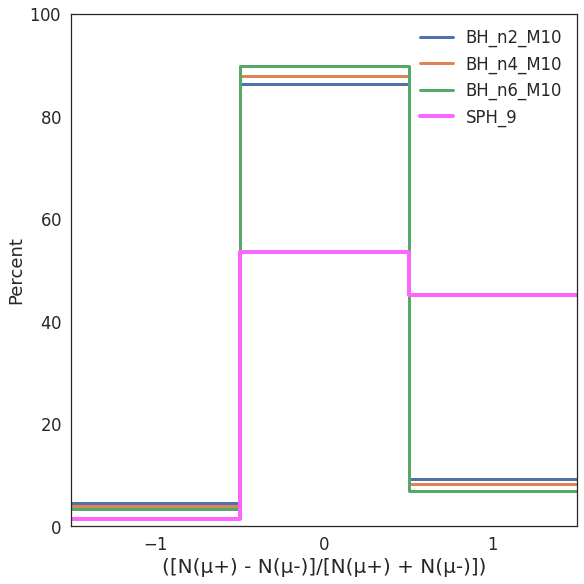

In [62]:
#Asymmetry
fig, axis = plt.subplots(ncols=1, figsize=(8, 8), layout="constrained")
#sn.histplot(dict(zip(BH_PLOT_LABELS + SPH_PLOT_LABELS, BH_asymmetry + sph_asymmetry)), ax = axis, binwidth=1, binrange=[-1.5, 1.5], 
           # multiple="layer", stat="count", linewidth=3, fill=False, palette=paper_colors)

for i in range(N_BH_LABELS):
    sn.histplot(BH_asymmetry[i], label=BH_PLOT_LABELS[i], linewidth=3, ax = axis, color=bh_colors[i], 
                binrange=[-1.5, 1.5], bins=3, fill=False, stat="percent", common_norm=False, element="step")
for i in range(N_SPH_LABELS):
    sn.histplot(sph_asymmetry[i], linewidth=4, label=SPH_PLOT_LABELS[i], ax = axis, color=sph_colors[i], 
                binrange=[-1.5, 1.5], bins=3, fill=False, stat="percent", common_norm=False, element="step")


axis.set_xlabel(r"([N(μ+) - N(μ-)]/[N(μ+) + N(μ-)])", size=20)
axis.set_xlim(-1.5, 1.5)
axis.set_xticks([-1, 0, 1])
#axis.set_ylim(0, 100)
axis.legend()

plt.plot()

In [63]:
#ST = scalar sum of all jets, leptons, photons and MET

def cut_pt_eta(array, pt_min, eta_max):
    array = ak.pad_none(array, 1, axis=-1)
    array = array[array.PT > pt_min]
    array = array[abs(array.Eta) < eta_max]
    n = np.array([len(event) for event in array.PT])
    return array, n

def cut_pt_eta_met(array, pt_min, eta_max):
    array = ak.pad_none(array, 1, axis=-1)
    #print(array, len(array))
    array = array[array.MET > pt_min]
    array = array[abs(array.Eta) < eta_max]
    return array

def calculate_ST(jets, muons, electrons, photons, met):
    ST = np.zeros(len(jets))
    jet_sum = np.sum(jets.PT, axis=-1)/1000
    muon_sum = np.sum(muons.PT, axis=-1)/1000
    electron_sum = np.sum(electrons.PT, axis=-1)/1000
    photon_sum = np.sum(photons.PT, axis=-1)/1000
    met_sum = np.sum(met.MET, axis=-1)/1000
    ST = jet_sum + muon_sum + electron_sum + photon_sum + met_sum
    return ST

def get_ST_N(n_labels, jets, muons, electrons, photons, met):
    ST = [ [] for _ in range(n_labels) ]
    N = [ [] for _ in range(n_labels) ]
    for i in range(n_labels):
        cut_jets, n_jets = cut_pt_eta(jets[i], PT_MIN, ETA_MAX)
        cut_muons, n_muons = cut_pt_eta(muons[i], PT_MIN, ETA_MAX)
        cut_electrons, n_electrons = cut_pt_eta(electrons[i], PT_MIN, ETA_MAX)
        cut_photons, n_photons = cut_pt_eta(photons[i], PT_MIN, ETA_MAX)
        cut_met = cut_pt_eta_met(met[i], PT_MIN, ETA_MAX)
        ST[i].append(calculate_ST(cut_jets, cut_muons, cut_electrons, cut_photons, cut_met))
        N[i].append(np.array(n_jets) + np.array(n_electrons) + np.array(n_muons) + np.array(n_photons))
        N[i] = N[i][0]
        ST[i] = ST[i][0]
    return ST, N

BH_ST, BH_N = get_ST_N(N_BH_LABELS, BH_jets, BH_muons, BH_electrons, BH_photons, BH_met)
sph_ST, SPH_N = get_ST_N(N_SPH_LABELS, sph_jets, sph_muons, sph_electrons, sph_photons, sph_met)

In [64]:
print(BH_ST[0][0:10])

[7.07, 7.67, 8.21, 8.36, 8.09, 8.85, 8.13, 8.72, 8.58, 8.3]


(6.0, 14.0)

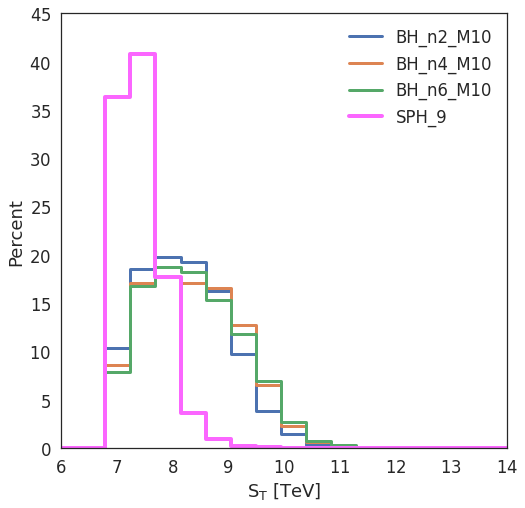

In [65]:
fig, ax = plt.subplots(ncols=1, figsize=(8, 8))
for i in range(N_BH_LABELS):
    sn.histplot(ak.to_numpy(BH_ST[i]), label=BH_PLOT_LABELS[i], linestyle=line_styles[i], linewidth=3, ax = ax, color=bh_colors[i],
    binrange=(5, 14), bins=20, fill=False, stat="percent", common_norm=False, element="step")
for i in range(N_SPH_LABELS):
    sn.histplot(ak.to_numpy(sph_ST[i]), label=SPH_PLOT_LABELS[i], linewidth=4, ax = ax, color=sph_colors[i],
    binrange=(5, 14), bins=20, fill=False, stat="percent", common_norm=False, element="step")
ax.legend()
ax.set_xlabel(r"$S_{T}$ [TeV]")
ax.set_xlim(6, 14)

[]

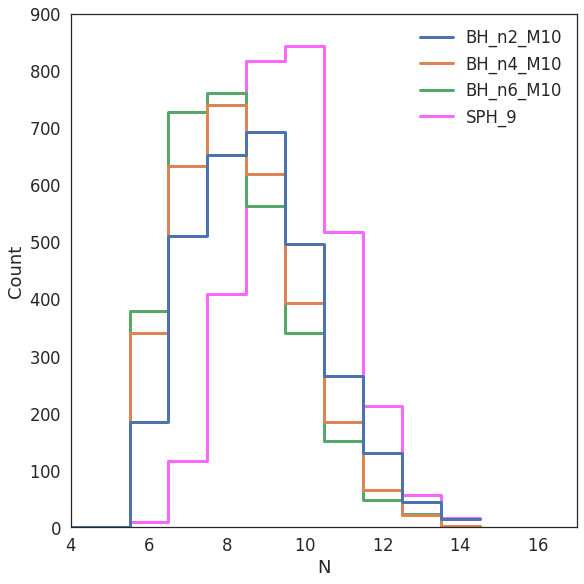

In [66]:
#N multiplicity
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), layout="constrained")
sn.histplot(dict(zip(BH_PLOT_LABELS + SPH_PLOT_LABELS, BH_N + SPH_N)), ax = ax, binwidth=1.0, binrange=[-0.5, 14.5], 
            multiple="layer", stat="count", linewidth=3, fill=False, palette=paper_colors, element="step")

ax.set_xlabel("N")
ax.set_xlim(4, 17)

plt.plot()

# Tower plots

In [67]:
#Pad Tower data
max_hits = np.max([np.max([len(event) for event in item["Eta"]]) for item in BH_clusters])
BH_clusters = [ak.pad_none(item, max_hits, axis=-1) for item in BH_clusters]

max_hits = np.max([np.max([len(event) for event in item["Eta"]]) for item in sph_clusters])
sph_clusters = [ak.pad_none(item, max_hits, axis=-1) for item in sph_clusters]

In [68]:
#Extracting data for plotting from clusters
#Gets the highest energy + position for each type of calorimeter as well as total transverse energy. 
#These do not necessarily correspond to the same angular position in the detector.
def get_values(item, energy_key):
    largest = ak.argmax(item[energy_key], axis=-1, keepdims=True)
    energy = ak.to_list(ak.flatten(item[energy_key][largest]))
    eta = ak.to_list(ak.flatten(item["Eta"][largest]))
    phi = ak.to_list(ak.flatten(item["Phi"][largest]))
    return energy, phi, eta

def calorimeter_values(clusters, N_EVENTS):
    cal_keys = ["ET", "Ehad", "Eem"]
    calorimeter = dict(zip(cal_keys, np.zeros((len(cal_keys), len(clusters), N_EVENTS))))
    for key in cal_keys:
        values = [get_values(item, key) for item in clusters]
        energy = [item[0] for item in values]
        phi = [item[1] for item in values]
        eta = [item[2] for item in values]
        calorimeter[key] = [energy, phi, eta]
    
    return calorimeter

BH_cal = calorimeter_values(BH_clusters, N_EVENTS)
sph_cal = calorimeter_values(sph_clusters, N_EVENTS)

STACKED histograms


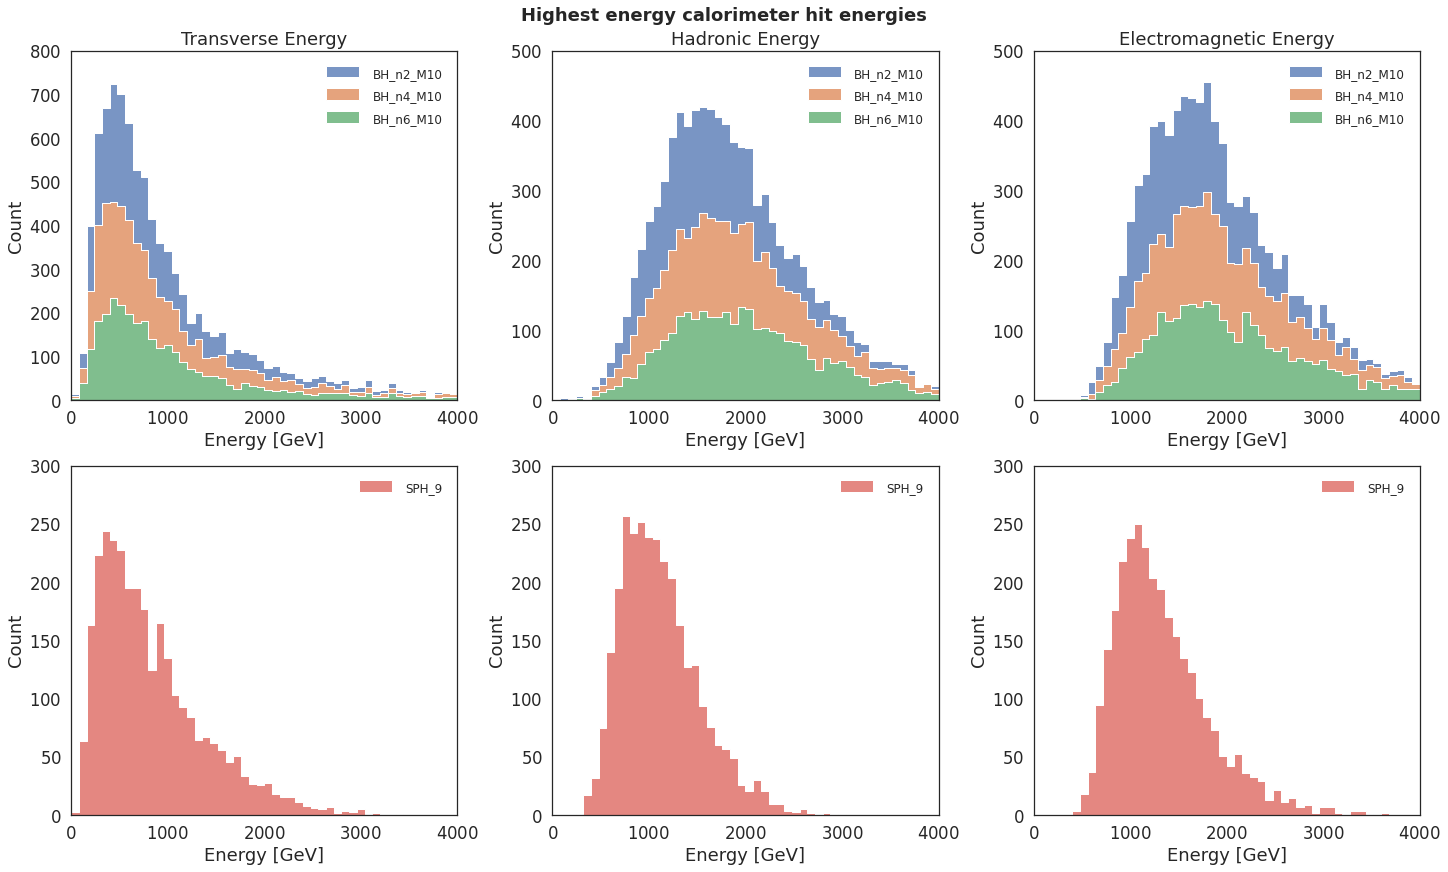

In [69]:
#Energy distribution
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20,12), layout="constrained")
fig.suptitle("Highest energy calorimeter hit energies", size=18, fontweight="bold")

sn.histplot(dict(zip(BH_PLOT_LABELS, BH_cal["Eem"][0])), ax = ax[0][0], bins=50, binrange=(0, 4000),
            multiple="stack", stat="count", element="step")
sn.histplot(dict(zip(SPH_PLOT_LABELS, sph_cal["Eem"][0])), ax = ax[1][0], bins=50, binrange=(0, 4000),
            multiple="stack", stat="count", element="step", palette="hls")
ax[0][2].set_title("Electromagnetic Energy")


sn.histplot(dict(zip(BH_PLOT_LABELS, BH_cal["Ehad"][0])), ax = ax[0][1], bins=50, binrange=(0, 4000),
            multiple="stack", stat="count", element="step")
sn.histplot(dict(zip(SPH_PLOT_LABELS, sph_cal["Ehad"][0])), ax = ax[1][1], bins=50, binrange=(0, 4000),
            multiple="stack", stat="count", element="step", palette="hls")
ax[0][1].set_title("Hadronic Energy")


sn.histplot(dict(zip(BH_PLOT_LABELS, BH_cal["ET"][0])), ax = ax[0][2], bins=50, binrange=(0, 4000), 
            multiple="stack", stat="count", element="step")
sn.histplot(dict(zip(SPH_PLOT_LABELS, sph_cal["ET"][0])), ax = ax[1][2], bins=50, binrange=(0, 4000),
            multiple="stack", stat="count", element="step", palette="hls")
ax[0][0].set_title("Transverse Energy")


for axis in ax.reshape(-1):
    axis.set_xlabel("Energy [GeV]")
    axis.set_xlim(0, 4000)
    plt.setp(axis.get_legend().get_texts(), fontsize='12')

print("STACKED histograms")

STACKED histograms


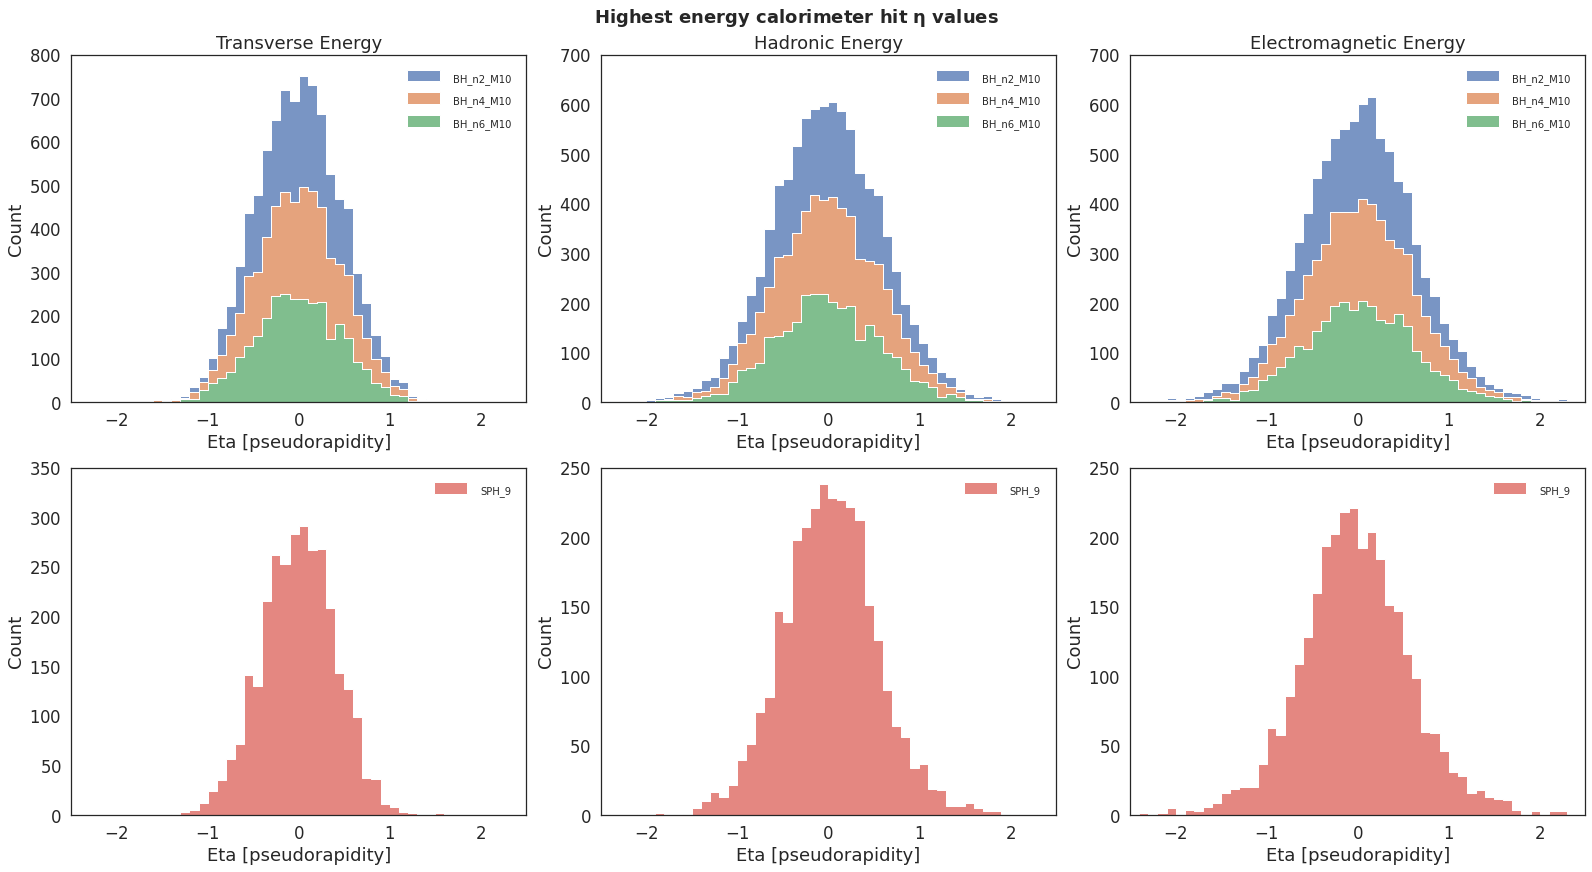

In [70]:
#Eta distribution
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(22,12), layout="constrained")
fig.suptitle(r"Highest energy calorimeter hit $\eta$ values", size=18, fontweight="bold")

sn.histplot(dict(zip(BH_PLOT_LABELS, BH_cal["ET"][2])), ax = ax[0][0], bins=50, binrange=(-2.5, 2.5), 
            multiple="stack", stat="count", element="step")
sn.histplot(dict(zip(SPH_PLOT_LABELS, sph_cal["ET"][2])), ax = ax[1][0], bins=50, binrange=(-2.5, 2.5), 
            multiple="stack", stat="count", element="step", palette="hls")
ax[0][0].set_title("Transverse Energy")

sn.histplot(dict(zip(BH_PLOT_LABELS, BH_cal["Ehad"][2])), ax = ax[0][1], bins=50, binrange=(-2.5, 2.5), 
            multiple="stack", stat="count", element="step")
sn.histplot(dict(zip(SPH_PLOT_LABELS, sph_cal["Ehad"][2])), ax = ax[1][1], bins=50, binrange=(-2.5, 2.5), 
            multiple="stack", stat="count", element="step", palette="hls")
ax[0][1].set_title("Hadronic Energy")

sn.histplot(dict(zip(BH_PLOT_LABELS, BH_cal["Eem"][2])), ax = ax[0][2], bins=50, binrange=(-2.5, 2.5), 
            multiple="stack", stat="count", element="step")
sn.histplot(dict(zip(SPH_PLOT_LABELS, sph_cal["Eem"][2])), ax = ax[1][2], bins=50, binrange=(-2.5, 2.5), 
            multiple="stack", stat="count", element="step", palette="hls")
ax[0][2].set_title("Electromagnetic Energy")

for axis in ax.reshape(-1):
    axis.set_xlabel("Eta [pseudorapidity]")
    axis.set_xlim(-2.5, 2.5)
    plt.setp(axis.get_legend().get_texts(), fontsize='10')

print("STACKED histograms")

STACKED histograms


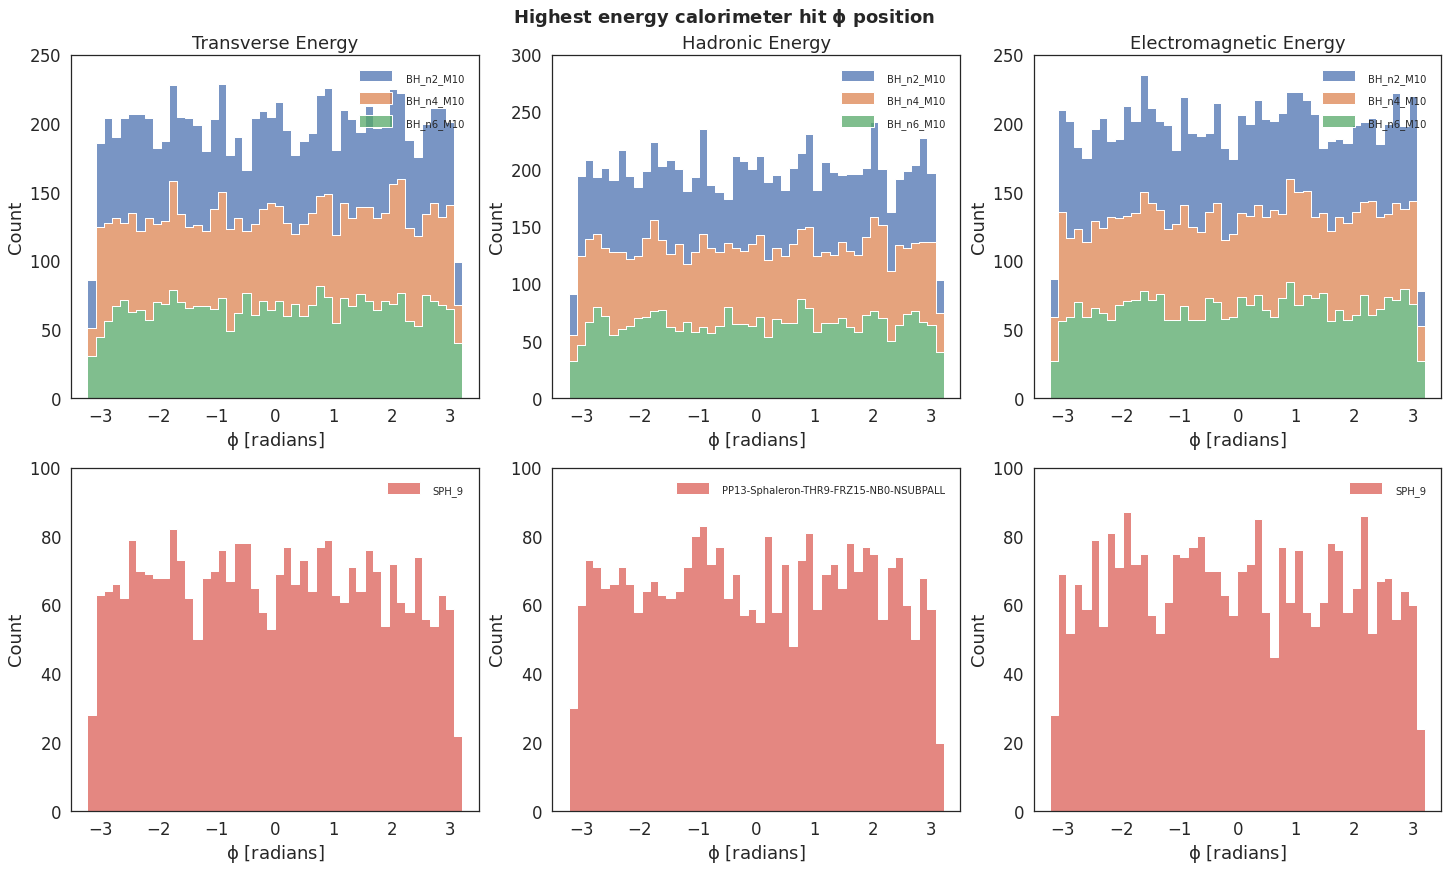

In [71]:
#Phi distribution, sanity check
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20,12), layout="constrained")
fig.suptitle(r"Highest energy calorimeter hit $\phi$ position", size=18, fontweight="bold")

sn.histplot(dict(zip(BH_PLOT_LABELS, BH_cal["ET"][1])), ax = ax[0][0], bins=50, binrange=(-3.5, 3.5), 
            multiple="stack", stat="count", element="step")
sn.histplot(dict(zip(SPH_PLOT_LABELS, sph_cal["ET"][1])), ax = ax[1][0], bins=50, binrange=(-3.5, 3.5), 
            multiple="stack", stat="count", element="step", palette="hls")
ax[0][0].set_title("Transverse Energy")

sn.histplot(dict(zip(BH_PLOT_LABELS, BH_cal["Ehad"][1])), ax = ax[0][1], bins=50, binrange=(-3.5, 3.5), 
            multiple="stack", stat="count", element="step")
sn.histplot(dict(zip(SPH_LABELS, sph_cal["Ehad"][1])), ax = ax[1][1], bins=50, binrange=(-3.5, 3.5), 
            multiple="stack", stat="count", element="step", palette="hls")
ax[0][1].set_title("Hadronic Energy")

sn.histplot(dict(zip(BH_PLOT_LABELS, BH_cal["Eem"][1])), ax = ax[0][2], bins=50, binrange=(-3.5, 3.5), 
            multiple="stack", stat="count", element="step")
sn.histplot(dict(zip(SPH_PLOT_LABELS, sph_cal["Eem"][1])), ax = ax[1][2], bins=50, binrange=(-3.5, 3.5), 
            multiple="stack", stat="count", element="step", palette="hls")
ax[0][2].set_title("Electromagnetic Energy")

for axis in ax.reshape(-1):
    axis.set_xlabel(r"$\phi$ [radians]")
    axis.set_xlim(-3.5, 3.5)
    plt.setp(axis.get_legend().get_texts(), fontsize='10')

print("STACKED histograms")